<a href="https://colab.research.google.com/github/surajsrivathsa/image_registration/blob/main/Direct_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from scipy.ndimage.interpolation import rotate

In [ ]:
import nibabel as nb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data creation

In [ ]:
fixed_img = np.zeros(shape=(1, 1, 128, 128, 128), dtype = np.float32)
fixed_img[:, :, 32:96, 32:96, 32:96] = 1.0

moving_img = np.zeros(shape=(1, 1, 128, 128, 128), dtype = np.float32)
moving_img[:, :, 50:114, 50:114, 50:114] = 1.0
#moving_img = rotate(moving_img, angle=45)

deformable_moving_img = np.zeros(shape=(1, 1, 128, 128, 128), dtype = np.float32)
deformable_moving_img[:, :, 36:100, 36:100, 36:100] = 1.0


In [ ]:
"""
fig = plt.figure()

#plt.subplot(1, 3, 1)
ax1 = fig.add_subplot(131)
ax1.title.set_text('Fixed')
plt.imshow(fixed_img[0, 0, 64, :, :])

#plt.subplot(1, 3, 2)

ax2 = fig.add_subplot(132)
ax2.title.set_text('Moving')
plt.imshow(moving_img[0, 0, 64, :, :])


ax3 = fig.add_subplot(133)
ax3.title.set_text('Warped')
#plt.subplot(1, 3, 3)
plt.imshow(warped_image_np[0, 0, 64, :, :])

plt.show()
"""

"\nfig = plt.figure()\n\n#plt.subplot(1, 3, 1)\nax1 = fig.add_subplot(131)\nax1.title.set_text('Fixed')\nplt.imshow(fixed_img[0, 0, 64, :, :])\n\n#plt.subplot(1, 3, 2)\n\nax2 = fig.add_subplot(132)\nax2.title.set_text('Moving')\nplt.imshow(moving_img[0, 0, 64, :, :])\n\n\nax3 = fig.add_subplot(133)\nax3.title.set_text('Warped')\n#plt.subplot(1, 3, 3)\nplt.imshow(warped_image_np[0, 0, 64, :, :])\n\nplt.show()\n"

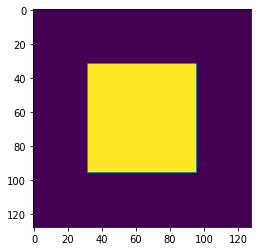

In [ ]:
plt.imshow(fixed_img[0, 0, 64, :, :])

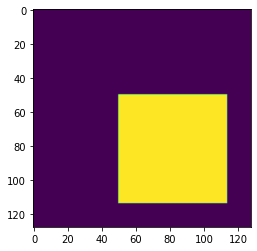

In [ ]:
plt.imshow(moving_img[0, 0, :, :, 70])

In [ ]:
fixed_img_tnsr = torch.from_numpy(fixed_img)
moving_img_tnsr = torch.from_numpy(moving_img)
deformable_moving_img_tnsr = torch.from_numpy(deformable_moving_img)

# Model Building

In [ ]:
class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """

    def __init__(self, size, is_affine=False, theta = None, mode='bilinear', affine_image_size =  (1, 1, 128, 128, 128)):
        super().__init__()

        self.mode = mode
        self.isaffine = is_affine
        self.theta = theta
        self.affine_image_size =  affine_image_size
        # create sampling grid
        # registering the grid as a buffer cleanly moves it to the GPU, but it also
        # adds it to the state dict. this is annoying since everything in the state dict
        # is included when saving weights to disk, so the model files are way bigger
        # than they need to be. so far, there does not appear to be an elegant solution.
        # see: https://discuss.pytorch.org/t/how-to-register-buffer-without-polluting-state-dict

        if (self.isaffine):
          grid = F.affine_grid(self.theta, self.affine_image_size, align_corners=False)
          #grid = grid.permute(0, 4, 1, 2, 3)
          self.register_buffer('grid', grid)
        else:
          vectors = [torch.arange(0, s) for s in size]
          grids = torch.meshgrid(vectors)
          grid = torch.stack(grids)
          grid = torch.unsqueeze(grid, 0)
          grid = grid.type(torch.FloatTensor)
          self.register_buffer('grid', grid)

    def forward(self, src, flow=None):      
      if (self.isaffine):
        grid = F.affine_grid(self.theta, self.affine_image_size)        
        warped_image = F.grid_sample(src, grid)
        #warped_image = warped_image.permute(0, 4, 1, 2, 3)
        return warped_image
      else:
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        # also not sure why, but the channels need to be reversed
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return F.grid_sample(src, new_locs, align_corners=True, mode=self.mode)


In [ ]:
sheared_affine_matrix = torch.from_numpy(np.array([ [ [1.0, 0.2, 0.1, 0.1], [ 0.3, 1.0, -0.1, -0.1], [-0.1,  -0.05, 1.0, 0.2] ] ], dtype="float32" ))
affine_matrix = torch.from_numpy(np.array([ [ [1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [0.0,  0.0, 1.0, 0.0] ] ], dtype="float32" ))

In [ ]:
spatial_transformer_affine = SpatialTransformer(size=(128, 128, 128), is_affine=True, theta=affine_matrix,  affine_image_size =  (1, 1, 128, 128, 128))
print(spatial_transformer_affine.grid.shape)
print(spatial_transformer_affine.isaffine)
print("========= =========== ======")
print()

torch.Size([1, 128, 128, 128, 3])
True
========= =========== ======



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


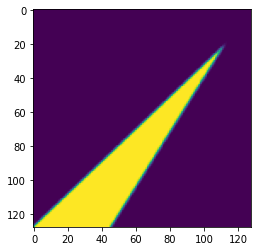

In [ ]:
moving_img_tnsr = spatial_transformer_affine(moving_img_tnsr)
moving_img = moving_img_tnsr.numpy()
plt.imshow(moving_img[0, 0, 50, :, :])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


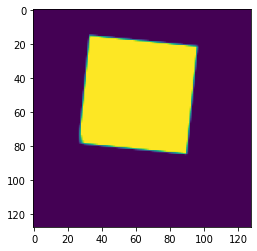

In [ ]:
warped_image_tensor = spatial_transformer_affine(fixed_img_tnsr)
warped_image_np = warped_image_tensor.numpy()
plt.imshow(warped_image_np[0, 0, :, 50, :])

In [ ]:
def normalized_cross_correlation(x, y, return_map, reduction='mean', eps=1e-8):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        x (~torch.Tensor): Input tensor.
        y (~torch.Tensor): Input tensor.
        return_map (bool): If True, also return the correlation map.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'sum'``.
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
    Returns:
        ~torch.Tensor: Output scalar
        ~torch.Tensor: Output tensor
    """

    shape = x.shape
    b = shape[0]

    # reshape
    x = x.view(b, -1)
    y = y.view(b, -1)

    # mean
    x_mean = torch.mean(x, dim=1, keepdim=True)
    y_mean = torch.mean(y, dim=1, keepdim=True)

    # deviation
    x = x - x_mean
    y = y - y_mean

    dev_xy = torch.mul(x,y)
    dev_xx = torch.mul(x,x)
    dev_yy = torch.mul(y,y)

    dev_xx_sum = torch.sum(dev_xx, dim=1, keepdim=True)
    dev_yy_sum = torch.sum(dev_yy, dim=1, keepdim=True)

    ncc = torch.div(dev_xy + eps / dev_xy.shape[1],
                    torch.sqrt( torch.mul(dev_xx_sum, dev_yy_sum)) + eps)
    ncc_map = ncc.view(b, *shape[1:])

    # reduce
    if reduction == 'mean':
        ncc = torch.mean(torch.sum(ncc, dim=1))
    elif reduction == 'sum':
        ncc = torch.sum(ncc)
    else:
        raise KeyError('unsupported reduction type: %s' % reduction)

    if not return_map:
        return ncc
    
    if (torch.isclose(torch.tensor([-1.0]).to("cuda"), ncc).any()):
      ncc = ncc + torch.tensor([0.01]).to("cuda")

    elif (torch.isclose(torch.tensor([1.0]).to("cuda"), ncc).any()):
      ncc = ncc - torch.tensor([0.01]).to("cuda")

    return ncc, ncc_map


In [ ]:
class NormalizedCrossCorrelation(nn.Module):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
        return_map (bool, optional): If True, also return the correlation map. Defaults to False.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'mean'``.
    """
    def __init__(self,
                 eps=1e-8,
                 return_map=False,
                 reduction='mean'):

        super(NormalizedCrossCorrelation, self).__init__()

        self._eps = eps
        self._return_map = return_map
        self._reduction = reduction

    def forward(self, x, y):

        return normalized_cross_correlation(x, y,self._return_map, self._reduction, self._eps)

In [ ]:
similarity_loss = NormalizedCrossCorrelation()
out = similarity_loss(fixed_img_tnsr, moving_img_tnsr)

In [ ]:
out

tensor(0.2815)

In [ ]:
myaffine = torch.from_numpy(np.array([ [ [1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [0.0,  0.0, 1.0, 0.0] ] ], dtype="float32" ))
myaffine.requires_grad_(requires_grad=True)

tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]]], requires_grad=True)

In [ ]:
# pass tensor in [], list is iterable
optimizer = torch.optim.Adam([myaffine], lr=2e-4 ) 

In [ ]:
# do steps next - loss out and back prop it, change myaffine matrix. 

In [ ]:
myaffine

tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]]], requires_grad=True)

# Affine Training Loop

**Translation warping**

In [ ]:
for step in range(1000):

  # Update spatial transformer affine matrix with new gradient descent updated matrix
  spatial_transformer_affine.theta = myaffine

  # Find warped image given moving image from spatial transformer
  warped_image_tensor = spatial_transformer_affine(moving_img_tnsr)

  # Find loss between warped image and fixed image
  total_loss = -1.0 * similarity_loss(fixed_img_tnsr, warped_image_tensor)
  # print(total_loss)

  # Backpropagate loss through network
  optimizer.zero_grad()          
  total_loss.backward()
  optimizer.step() 

  # Print losses
  if(step % 10 == 0):
    print("Loss at step {} is : {}".format(step, total_loss))
    print("Affine matrix is: {}".format(myaffine))
    print("============= ================ =============== =========")
    print()

  del warped_image_tensor

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Loss at step 0 is : -0.8827527761459351
Affine matrix is: tensor([[[1.0656, 0.0456, 0.0456, 0.2448],
         [0.0456, 1.0656, 0.0456, 0.2448],
         [0.0456, 0.0456, 1.0656, 0.2448]]], requires_grad=True)
============= ================ =============== =========

Loss at step 10 is : -0.8880446553230286
Affine matrix is: tensor([[[1.0625, 0.0432, 0.0432, 0.2466],
         [0.0432, 1.0625, 0.0432, 0.2466],
         [0.0432, 0.0432, 1.0625, 0.2466]]], requires_grad=True)
============= ================ =============== =========

Loss at step 20 is : -0.8934895992279053
Affine matrix is: tensor([[[1.0594, 0.0407, 0.0407, 0.2484],
         [0.0407, 1.0594, 0.0407, 0.2484],
         [0.0407, 0.0407, 1.0594, 0.2484]]], requires_grad=True)
============= ================ =============== =========

Loss at step 30 is : -0.8990345597267151
Affine matrix is: tensor([[[1.0563, 0.0382, 0.0382, 0.2502],
         [0.0382, 1.0563, 0.0382, 0.2502],
         [0.0382, 0.0382, 1.0563, 0.2502]]], require

**Full Affine warping**

In [ ]:
for step in range(501):

  # Update spatial transformer affine matrix with new gradient descent updated matrix
  spatial_transformer_affine.theta = myaffine

  # Find warped image given moving image from spatial transformer
  warped_image_tensor = spatial_transformer_affine(moving_img_tnsr)

  # Find loss between warped image and fixed image
  total_loss = -1.0 * similarity_loss(fixed_img_tnsr, warped_image_tensor)
  # print(total_loss)

  # Backpropagate loss through network
  optimizer.zero_grad()          
  total_loss.backward()
  optimizer.step() 

  # Print losses
  if(step % 100 == 0):
    print("Loss at step {} is : {}".format(step, total_loss))
    print("Affine matrix is: {}".format(myaffine))
    print("============= ================ =============== =========")
    print()

  del warped_image_tensor

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Loss at step 0 is : -0.9384267330169678
Affine matrix is: tensor([[[ 1.1201, -0.4260, -0.2686, -0.0734],
         [-0.5369,  1.1411,  0.2756,  0.4441],
         [ 0.1807,  0.0411,  0.9799, -0.0779]]], requires_grad=True)
============= ================ =============== =========

Loss at step 100 is : -0.9384292960166931
Affine matrix is: tensor([[[ 1.1206, -0.4261, -0.2688, -0.0735],
         [-0.5382,  1.1414,  0.2760,  0.4443],
         [ 0.1806,  0.0411,  0.9799, -0.0779]]], requires_grad=True)
============= ================ =============== =========

Loss at step 200 is : -0.9384305477142334
Affine matrix is: tensor([[[ 1.1211, -0.4261, -0.2691, -0.0735],
         [-0.5393,  1.1416,  0.2767,  0.4445],
         [ 0.1806,  0.0411,  0.9799, -0.0779]]], requires_grad=True)
============= ================ =============== =========

Loss at step 300 is : -0.9384316205978394
Affine matrix is: tensor([[[ 1.1214, -0.4261, -0.2692, -0.0736],
         [-0.5402,  1.1417,  0.2770,  0.4446],
     

# Affine Inference

Full Affine Warping

In [ ]:
myaffine

tensor([[[ 1.1218, -0.4260, -0.2694, -0.0737],
         [-0.5412,  1.1417,  0.2774,  0.4448],
         [ 0.1805,  0.0411,  0.9800, -0.0779]]], requires_grad=True)

In [ ]:
warped_image_tensor = spatial_transformer_affine(moving_img_tnsr)
warped_image_tensor = warped_image_tensor.detach().to("cpu")
warped_image_np = warped_image_tensor.numpy()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


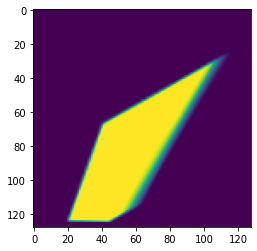

In [ ]:
# 100 iteration
plt.imshow(warped_image_np[0, 0, 32, :, :])

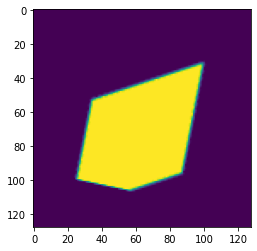

In [ ]:
# 600 iteration
plt.imshow(warped_image_np[0, 0, 50, :, :])

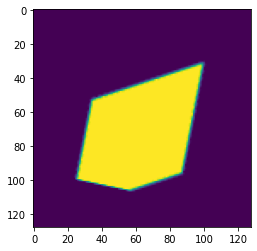

In [ ]:
# 1100 iteration
plt.imshow(warped_image_np[0, 0, 50, :, :])

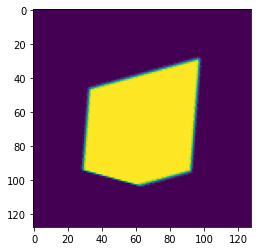

In [ ]:
# 1700 iteration
plt.imshow(warped_image_np[0, 0, 50, :, :])

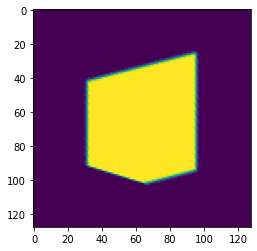

In [ ]:
# 2200 iteration
plt.imshow(warped_image_np[0, 0, 50, :, :])

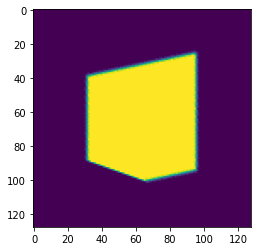

In [ ]:
# 2700 iteration
plt.imshow(warped_image_np[0, 0, 50, :, :])

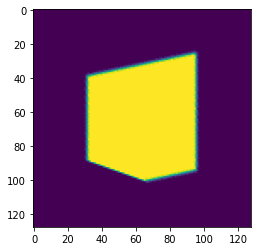

In [ ]:
# 3200 iteration
plt.imshow(warped_image_np[0, 0, 50, :, :])

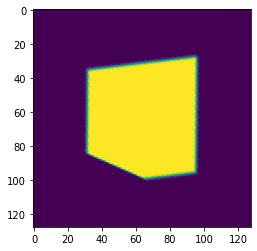

In [ ]:
# 3700 iteration
plt.imshow(warped_image_np[0, 0, 50, :, :])

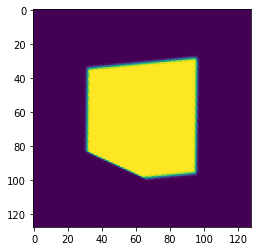

In [ ]:
# 4200 iteration
plt.imshow(warped_image_np[0, 0, 50, :, :])

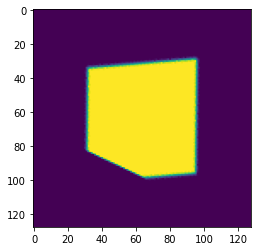

In [ ]:
# 4700 iteration
plt.imshow(warped_image_np[0, 0, 50, :, :])

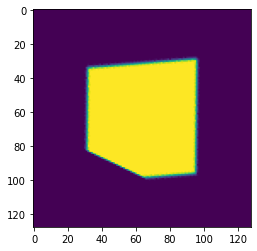

In [ ]:
# 5200 iteration
plt.imshow(warped_image_np[0, 0, 50, :, :])

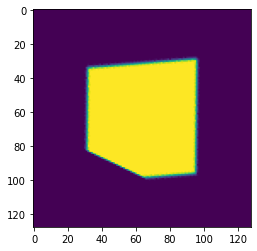

In [ ]:
# 5200 iteration
plt.imshow(warped_image_np[0, 0, 50, :, :])

**Only Translated images warping**

fixed_img[:, :, 32:96, 32:96, 32:96] = 1.0


moving_img[:, :, 50:114, 50:114, 50:114] = 1.0

**As we can see  we just wanted translation parameters to be maximum as our data was not rotated/sheared and only translated, but we observe that due to gradient descent there are small amounts of value for rotation and shearing. This resulted in slightly slanted warped image.**

In [ ]:
myaffine

tensor([[[ 1.0000e+00,  1.7439e-08,  1.1416e-08,  2.8125e-01],
         [-2.0404e-08,  1.0000e+00,  1.0382e-08,  2.8125e-01],
         [-1.7831e-08,  1.5549e-08,  1.0000e+00,  2.8125e-01]]],
       requires_grad=True)

In [ ]:
warped_image_tensor = spatial_transformer_affine(moving_img_tnsr)
warped_image_tensor = warped_image_tensor.detach().to("cpu")
warped_image_np = warped_image_tensor.numpy()


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


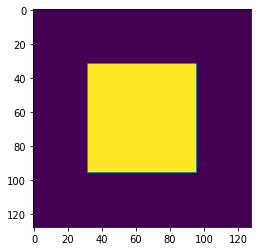

In [ ]:
# 1700 iteration
plt.imshow(warped_image_np[0, 0, 32, :, :])

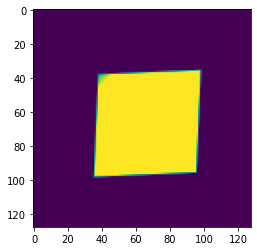

In [ ]:
# 1200 iteration
plt.imshow(warped_image_np[0, 0, 38, :, :])

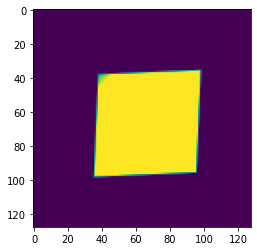

In [ ]:
# 1000 iteration
plt.imshow(warped_image_np[0, 0, 38, :, :])

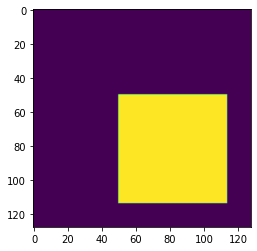

In [ ]:
moving_image_np = moving_img_tnsr.numpy()
plt.imshow(moving_image_np[0, 0, 113, :, :])

# Affine Brain Data preprocessing

In [ ]:
def load_3D( name):
        # model_np = np.zeros(shape=(160, 192, 224))
        # X_nb = nb.load(name)
        # X_np = X_nb.dataobj
        # #print("Oreintation: {}".format(nb.aff2axcodes(X_nb.affine)))
        # model_np[:, :, :] = X_np[42:202, 32:224, 16:240]
        # #model_np = np.reshape(model_np, (1,)+ model_np.shape)
        # return model_np
        resamplng_shape = (128, 128, 128)
        

        X_nb = nb.load(name)
        X_np = X_nb.dataobj
        least_intensity = np.min(X_np)
        model_np = np.full(shape=resamplng_shape, fill_value=least_intensity)

        #X_np = imgnorm(X_np_old)
        x_dim, y_dim, z_dim = X_np.shape
        x_ltail = (resamplng_shape[0] - x_dim)//2 
        y_ltail = (resamplng_shape[1] - y_dim)//2
        z_ltail = (resamplng_shape[2] - z_dim)//2

        x_rtail = resamplng_shape[0] - x_ltail - 1
        y_rtail = resamplng_shape[1] - y_ltail - 1
        z_rtail = resamplng_shape[2] - z_ltail - 1
        #print("Oreintation: {}".format(nb.aff2axcodes(X_nb.affine)))
        #model_np[:, :, :] = X_np[42:202, 32:224, 16:240]
        model_np[x_ltail:x_rtail, y_ltail:y_rtail, z_ltail:z_rtail] = X_np[:, :, :]
        model_np = np.reshape(model_np, (1,)+ model_np.shape)
        model_np = np.reshape(model_np, (1,)+ model_np.shape)
        #myimg = imgnorm(model_np)
        return model_np


def imgnorm(N_I,index1=0.0001,index2=0.0001):
        I_sort = np.sort(N_I.flatten())
        I_min = I_sort[int(index1*len(I_sort))]
        I_max = I_sort[-int(index2*len(I_sort))]
        N_I =1.0*(N_I-I_min)/(I_max-I_min)
        N_I[N_I>1.0]=1.0
        N_I[N_I<0.0]=0.0
        N_I2 = N_I.astype(np.float32)
        return N_I2


def Norm_Zscore( img):
        img= (img-np.mean(img))/np.std(img) 
        return img


def run3functions( fp):
        myimg = load_3D(fp)
        #myimg1 = Norm_Zscore(imgnorm(myimg))
        myimg2 = imgnorm(myimg)
        return myimg2

In [ ]:
fixed_file_path = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/reg_IXI060-Guys-0709-T1_downsampled_hm_zscore.nii.gz"
moving_file_path = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/reg_IXI436-HH-2153-T1_downsampled_hm_zscore.nii.gz"


In [ ]:
fixed_img = run3functions(fixed_file_path)
moving_img = run3functions(moving_file_path)
deformable_moving_img = moving_img

fixed_img_tnsr = torch.from_numpy(fixed_img)
moving_img_tnsr = torch.from_numpy(moving_img)
deformable_moving_img_tnsr = torch.from_numpy(deformable_moving_img)

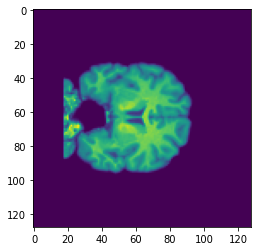

In [ ]:
plt.imshow(fixed_img[0, 0, :, 75, :])

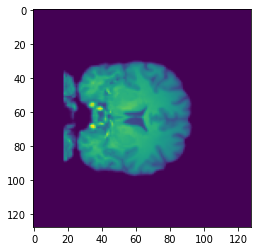

In [ ]:
plt.imshow(moving_img[0, 0, :, 75, :])

In [ ]:
rotated_affine_matrix = torch.from_numpy(np.array([ [ [0.0, 0.0, -1.0, 0.1], [ 0.0, -1.0, 0.0, 0.1], [-1.0,  0.0, 0.0, 0.1] ] ], dtype="float32" ))
affine_matrix = torch.from_numpy(np.array([ [ [1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [0.0,  0.0, 1.0, 0.0] ] ], dtype="float32" ))
spatial_transformer_affine = SpatialTransformer(size=(128, 128, 128), is_affine=True, theta=rotated_affine_matrix,  affine_image_size =  (1, 1, 128, 128, 128))
spatial_transformer_training = SpatialTransformer(size=(128, 128, 128), is_affine=True, theta=affine_matrix, affine_image_size =  (1, 1, 128, 128, 128))

In [ ]:
# Rotate moving image volume by 90deg and add a bit of translation at x, y and z axis
moving_img_tnsr_new = spatial_transformer_affine(moving_img_tnsr)
moving_img_tnsr_new_np = moving_img_tnsr_new.numpy()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


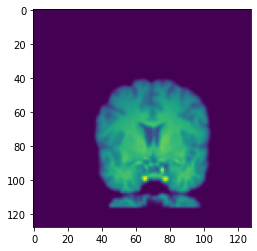

In [ ]:
plt.imshow(moving_img_tnsr_new_np[0, 0, :, 59, :])

In [ ]:
similarity_loss = NormalizedCrossCorrelation()


In [ ]:
myaffine = torch.from_numpy(np.array([ [ [1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [0.0,  0.0, 1.0, 0.0] ] ], dtype="float32" ))
myaffine.requires_grad_(requires_grad=True)

tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]]], requires_grad=True)

In [ ]:
# pass tensor in [], list is iterable
optimizer = torch.optim.Adam([myaffine], lr=2e-4 ) 

# Affine brain training

In [ ]:
for step in range(2000):

  # Update spatial transformer affine matrix with new gradient descent updated matrix
  spatial_transformer_training.theta = myaffine

  # Find warped image given moving image from spatial transformer
  warped_image_tensor = spatial_transformer_training(moving_img_tnsr_new)

  # Find loss between warped image and fixed image
  total_loss = -1.0 * similarity_loss(fixed_img_tnsr, warped_image_tensor)
  # print(total_loss)

  # Backpropagate loss through network
  optimizer.zero_grad()          
  total_loss.backward()
  optimizer.step() 

  # Print losses
  if(step % 100 == 0):
    print("Loss at step {} is : {}".format(step, total_loss))
    print("Affine matrix is: {}".format(myaffine))
    print("============= ================ =============== =========")
    print()

  del warped_image_tensor

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Loss at step 0 is : -0.8610689043998718
Affine matrix is: tensor([[[ 0.8993,  0.0631,  0.2514,  0.2101],
         [-0.1839,  1.0067,  0.1507,  0.1454],
         [-0.2253, -0.0495,  1.0025,  0.1918]]], requires_grad=True)
============= ================ =============== =========

Loss at step 100 is : -0.8611527681350708
Affine matrix is: tensor([[[ 0.8991,  0.0563,  0.2598,  0.2095],
         [-0.1773,  1.0065,  0.1587,  0.1461],
         [-0.2325, -0.0545,  0.9998,  0.1909]]], requires_grad=True)
============= ================ =============== =========

Loss at step 200 is : -0.861234724521637
Affine matrix is: tensor([[[ 0.8981,  0.0495,  0.2683,  0.2091],
         [-0.1719,  1.0067,  0.1656,  0.1465],
         [-0.2406, -0.0597,  0.9973,  0.1900]]], requires_grad=True)
============= ================ =============== =========

Loss at step 300 is : -0.861321210861206
Affine matrix is: tensor([[[ 0.8970,  0.0439,  0.2767,  0.2085],
         [-0.1676,  1.0059,  0.1744,  0.1470],
       

# Affine brain inference

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


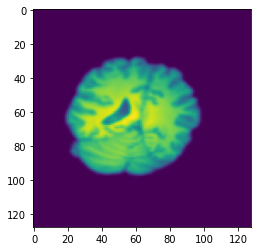

In [ ]:
warped_image_tnsr = spatial_transformer_training(moving_img_tnsr_new)
warped_image_np = warped_image_tnsr.detach().to("cpu").numpy()
plt.imshow(warped_image_np[0, 0, :, 75, :])

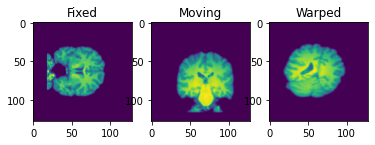

In [ ]:

fig = plt.figure()

#plt.subplot(1, 10, 1)
ax1 = fig.add_subplot(131)
ax1.title.set_text('Fixed')
plt.imshow(fixed_img[0, 0, :, 75, :])

#plt.subplot(1, 10, 2)

ax2 = fig.add_subplot(132)
ax2.title.set_text('Moving')
plt.imshow(moving_img_tnsr_new_np[0, 0, :, 75, :])


ax3 = fig.add_subplot(133)
ax3.title.set_text('Warped')
#plt.subplot(1, 10, 3)
plt.imshow(warped_image_np[0, 0, :, 75, :])

plt.show()

# Deformable Data preprocessing

In [ ]:
def load_3D( name):
        # model_np = np.zeros(shape=(160, 192, 224))
        # X_nb = nb.load(name)
        # X_np = X_nb.dataobj
        # #print("Oreintation: {}".format(nb.aff2axcodes(X_nb.affine)))
        # model_np[:, :, :] = X_np[42:202, 32:224, 16:240]
        # #model_np = np.reshape(model_np, (1,)+ model_np.shape)
        # return model_np
        resamplng_shape = (128, 128, 128)
        

        X_nb = nb.load(name)
        X_np = X_nb.dataobj
        least_intensity = np.min(X_np)
        model_np = np.full(shape=resamplng_shape, fill_value=least_intensity)

        #X_np = imgnorm(X_np_old)
        x_dim, y_dim, z_dim = X_np.shape
        x_ltail = (resamplng_shape[0] - x_dim)//2 
        y_ltail = (resamplng_shape[1] - y_dim)//2
        z_ltail = (resamplng_shape[2] - z_dim)//2

        x_rtail = resamplng_shape[0] - x_ltail - 1
        y_rtail = resamplng_shape[1] - y_ltail - 1
        z_rtail = resamplng_shape[2] - z_ltail - 1
        #print("Oreintation: {}".format(nb.aff2axcodes(X_nb.affine)))
        #model_np[:, :, :] = X_np[42:202, 32:224, 16:240]
        model_np[x_ltail:x_rtail, y_ltail:y_rtail, z_ltail:z_rtail] = X_np[:, :, :]
        model_np = np.reshape(model_np, (1,)+ model_np.shape)
        model_np = np.reshape(model_np, (1,)+ model_np.shape)
        #myimg = imgnorm(model_np)
        return model_np


def imgnorm(N_I,index1=0.0001,index2=0.0001):
        I_sort = np.sort(N_I.flatten())
        I_min = I_sort[int(index1*len(I_sort))]
        I_max = I_sort[-int(index2*len(I_sort))]
        N_I =1.0*(N_I-I_min)/(I_max-I_min)
        N_I[N_I>1.0]=1.0
        N_I[N_I<0.0]=0.0
        N_I2 = N_I.astype(np.float32)
        return N_I2


def Norm_Zscore( img):
        img= (img-np.mean(img))/np.std(img) 
        return img


def run3functions( fp):
        myimg = load_3D(fp)
        #myimg1 = Norm_Zscore(imgnorm(myimg))
        myimg2 = imgnorm(myimg)
        return myimg2



In [ ]:
fixed_file_path = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/reg_IXI060-Guys-0709-T1_downsampled_hm_zscore.nii.gz"
moving_file_path = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/reg_IXI436-HH-2153-T1_downsampled_hm_zscore.nii.gz"


In [ ]:
fixed_img = run3functions(fixed_file_path)
moving_img = run3functions(moving_file_path)
deformable_moving_img = moving_img

fixed_img_tnsr = torch.from_numpy(fixed_img)
moving_img_tnsr = torch.from_numpy(moving_img)
deformable_moving_img_tnsr = torch.from_numpy(deformable_moving_img)

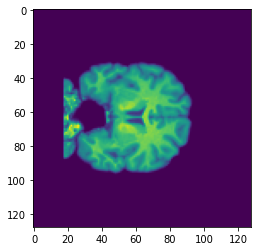

In [ ]:
plt.imshow(fixed_img[0, 0, :, 75, :])

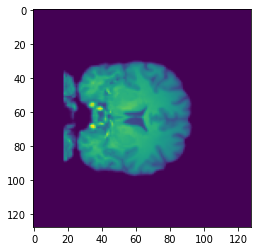

In [ ]:
plt.imshow(moving_img[0, 0, :, 75, :])

# Deformable Training

In [ ]:
deformable_tnsr = torch.randn(size = (1,3,128,128,128)) * 0.001
deformable_tnsr.requires_grad_(requires_grad=True)

tensor([[[[[-7.7470e-04,  4.5508e-04,  6.3131e-04,  ..., -1.7866e-04,
            -1.6613e-04, -1.6975e-03],
           [ 2.3432e-04,  9.9035e-04, -1.0776e-03,  ..., -1.3873e-03,
             1.3051e-03, -9.2085e-04],
           [-8.0651e-05, -5.8933e-04,  5.5802e-04,  ...,  5.1212e-05,
            -6.5196e-04, -3.4634e-04],
           ...,
           [ 1.7244e-03,  9.4769e-04,  9.5580e-04,  ..., -6.5652e-05,
            -1.7822e-04,  1.4941e-04],
           [ 3.0759e-04, -2.2253e-03, -1.2551e-03,  ...,  1.6514e-03,
            -1.3508e-04,  9.7079e-04],
           [-1.6169e-04, -1.2301e-03, -8.6050e-04,  ...,  1.0702e-03,
             1.5002e-03, -5.2070e-05]],

          [[ 2.9663e-04, -1.1975e-03,  8.4068e-04,  ...,  8.7691e-04,
             7.1177e-04, -7.7795e-04],
           [ 6.1076e-04, -6.1518e-04,  2.4515e-04,  ...,  1.0526e-03,
             4.1760e-04, -5.9694e-04],
           [ 5.8482e-04,  7.9002e-05, -4.2526e-04,  ..., -1.7278e-04,
             1.6054e-03, -1.5268e-03],
 

In [ ]:
spatial_transformer_deformable = SpatialTransformer(size=(128, 128, 128), is_affine=False, affine_image_size =  (1, 1, 128, 128, 128))

In [ ]:
warped_image_tnsr = spatial_transformer_deformable(deformable_moving_img_tnsr, deformable_tnsr)
warped_image_np = warped_image_tnsr.detach().to("cpu").numpy()


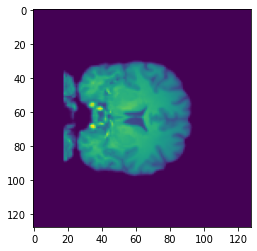

In [ ]:
plt.imshow(warped_image_np[0, 0, :, 75, :])

In [ ]:
# pass tensor in [], list is iterable
optimizer = torch.optim.Adam([deformable_tnsr], lr=2e-4 ) 

In [ ]:
similarity_loss = NormalizedCrossCorrelation()
out = similarity_loss(fixed_img_tnsr, moving_img_tnsr)
out

tensor(0.9447)

In [ ]:
for step in range(501):

  # Find warped image given moving image from spatial transformer
  warped_image_tensor = spatial_transformer_deformable(deformable_moving_img_tnsr, deformable_tnsr)

  # Find loss between warped image and fixed image
  total_loss = -1.0 * similarity_loss(fixed_img_tnsr, warped_image_tensor)
  # print(total_loss)

  # Backpropagate loss through network
  optimizer.zero_grad()          
  total_loss.backward()
  optimizer.step() 

  # Print losses
  if(step % 10 == 0):
    print("Loss at step {} is : {}".format(step, total_loss))
    # print("Affine matrix is: {}".format(myaffine))
    print("============= ================ =============== =========")
    print()

  del warped_image_tensor

Loss at step 0 is : -0.9464660882949829
============= ================ =============== =========

Loss at step 10 is : -0.9466342329978943
============= ================ =============== =========

Loss at step 20 is : -0.9468015432357788
============= ================ =============== =========

Loss at step 30 is : -0.9469679594039917
============= ================ =============== =========

Loss at step 40 is : -0.9471337795257568
============= ================ =============== =========

Loss at step 50 is : -0.9472981691360474
============= ================ =============== =========

Loss at step 60 is : -0.9474618434906006
============= ================ =============== =========

Loss at step 70 is : -0.9476245641708374
============= ================ =============== =========

Loss at step 80 is : -0.9477866291999817
============= ================ =============== =========

Loss at step 90 is : -0.9479477405548096
============= ================ =============== =========

Loss at ste

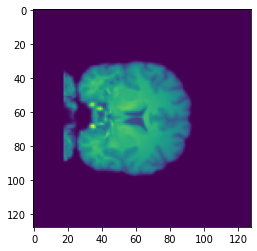

In [ ]:
warped_image_tnsr = spatial_transformer_deformable(deformable_moving_img_tnsr, deformable_tnsr)
warped_image_np = warped_image_tnsr.detach().to("cpu").numpy()
plt.imshow(warped_image_np[0, 0, :, 75, :])

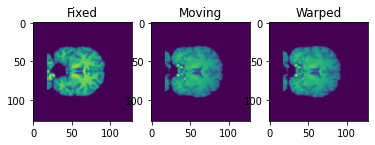

In [ ]:

fig = plt.figure()

#plt.subplot(1, 10, 1)
ax1 = fig.add_subplot(131)
ax1.title.set_text('Fixed')
plt.imshow(fixed_img[0, 0, :, 75, :])

#plt.subplot(1, 10, 2)

ax2 = fig.add_subplot(132)
ax2.title.set_text('Moving')
plt.imshow(deformable_moving_img[0, 0, :, 75, :])


ax3 = fig.add_subplot(133)
ax3.title.set_text('Warped')
#plt.subplot(1, 10, 3)
plt.imshow(warped_image_np[0, 0, :, 75, :])

plt.show()


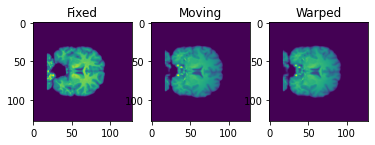

In [ ]:
fig = plt.figure()

#plt.subplot(1, 10, 1)
ax1 = fig.add_subplot(131)
ax1.title.set_text('Fixed')
plt.imshow(fixed_img[0, 0, :, 75, :])

#plt.subplot(1, 10, 2)

ax2 = fig.add_subplot(132)
ax2.title.set_text('Moving')
plt.imshow(deformable_moving_img[0, 0, :, 75, :])


ax3 = fig.add_subplot(133)
ax3.title.set_text('Warped')
#plt.subplot(1, 10, 3)
plt.imshow(warped_image_np[0, 0, :, 75, :])

plt.show()

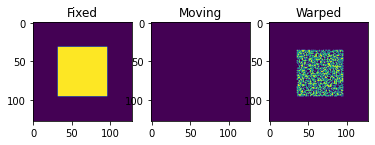

In [ ]:

fig = plt.figure()

#plt.subplot(1, 10, 1)
ax1 = fig.add_subplot(131)
ax1.title.set_text('Fixed')
plt.imshow(fixed_img[0, 0, 35, :, :])

#plt.subplot(1, 10, 2)

ax2 = fig.add_subplot(132)
ax2.title.set_text('Moving')
plt.imshow(deformable_moving_img[0, 0, 35, :, :])


ax3 = fig.add_subplot(133)
ax3.title.set_text('Warped')
#plt.subplot(1, 10, 3)
plt.imshow(warped_image_np[0, 0, 35, :, :])

plt.show()


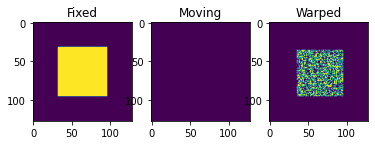

In [ ]:

fig = plt.figure()

#plt.subplot(1, 10, 1)
ax1 = fig.add_subplot(131)
ax1.title.set_text('Fixed')
plt.imshow(fixed_img[0, 0, 35, :, :])

#plt.subplot(1, 10, 2)

ax2 = fig.add_subplot(132)
ax2.title.set_text('Moving')
plt.imshow(deformable_moving_img[0, 0, 35, :, :])


ax3 = fig.add_subplot(133)
ax3.title.set_text('Warped')
#plt.subplot(1, 10, 3)
plt.imshow(warped_image_np[0, 0, 35, :, :])

plt.show()


# Deformable Inference